In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Bio

sys.path.insert(0,'../')
from PhicoreModules import parse_genbank, mean, median, mode, visualise

In [2]:
def coding_regions(entry: Bio.SeqRecord.SeqRecord, verbose: bool = False) -> list[int]:
    """
    calculate a list of ints of the regions that are coding for the record
    
    :param record: The genbank record entry (ie. one sequence record)
    :param verbose: more output
    :return : a list of 1's and 0's. 1: the base is encoding. 0: the base is not
    """
    
    seqlen = len(entry.seq)
    coding = [0 for i in range(seqlen)]
    fn = {'CDS': 0, 'tRNA': 0}
    for feat in entry.features:
        if feat.type != 'CDS' and feat.type != 'tRNA':
            print(f"Skipped feature of type: {feat.type}", file=sys.stderr)
            continue
        fn[feat.type] = fn.get(feat.type, 0) + 1
        (start, stop, strand) = (feat.location.start.position, feat.location.end.position, feat.strand)
        for i in range(start, stop):
            coding[i] = 1
    if verbose:
        print(f"Found {fn['CDS']} CDS and {fn['tRNA']} tRNA", file=sys.stderr)
    return coding

In [3]:
def coding_stats(coding: list[int], window: int, step: int, verbose: bool = False) -> dict[str, int]:
    """
    Calculate the statistics for this coding window
    :param coding: the list of coding/not coding regions(a list of 1's and 0's)
    :param window: the window to calculate the average across
    :param step: the step size between windows
    :param verbose: more output
    :return : a dictionary summaring the statistics
    """
    
    winbeg = 0
    allcd = {}

    while winbeg + step + window < len(coding):
        winend = winbeg + window
        cd = sum(coding[winbeg:winend])/window
        allcd[winbeg] = cd
        winbeg += step
    
    return {
        'mean': sum(allcd.values())/len(allcd.values()),
        'median' : median(list(allcd.values())),
        'mode': mode(allcd.values()),
        'minimum': min(allcd.values()),
        'maximum': max(allcd.values()),
        'all': allcd
    }
        

In [4]:
def calc_coding_density(filestub, gbkdir = '../genbank/'):
    codden = pd.DataFrame()
    data = {}
    coding = []
    for file in os.listdir(gbkdir):
        if not filestub in file:
            continue
        seq = parse_genbank(os.path.join(gbkdir, file))

        for entry in seq.records:
            coding = coding_regions(entry, verbose=True)
            stats = coding_stats(coding, 2000, 150)
            data[file] = [stats['mean'], stats['median'], stats['mode'], stats['minimum'], stats['maximum']]
            if codden.empty:
                codden = pd.DataFrame.from_dict(stats['all'], orient='index',columns=[file]).reset_index()
                codden = codden.rename(columns={'index': 'x'})
            else:
                codden[file] = codden['x'].map(stats['all'])

    return pd.DataFrame.from_dict(data, orient='index', columns=['mean', 'median', 'mode', 'minimum', 'maximum']), codden

In [5]:
summary, cod = calc_coding_density(filestub='Bc01.fasta')

/home/edwa0468/.local/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 123 CDS and 19 tRNA
Skipped feature of type: source
Found 123 CDS and 20 tRNA
Skipped feature of type: source
Found 119 CDS and 22 tRNA
Skipped feature of type: source
Found 112 CDS and 20 tRNA
Skipped feature of type: source
Found 100 CDS and 13 tRNA
Skipped feature of type: source
Found 118 CDS and 22 tRNA
Skipped feature of type: source
Found 96 CDS and 9 tRNA


In [6]:
summary

,mean,median,mode,minimum,maximum
Bc01.fasta-TAA.gbk,0.965615,0.9845,1.0,0.7805,1.0
Bc01.fasta-TAG-TAA.gbk,0.967021,0.9920,1.0,0.6805,1.0
Bc01.fasta-TAG-TGA-TAA.gbk,0.965008,0.9905,1.0,0.6210,1.0
Bc01.fasta-TAG-TGA.gbk,0.974405,0.9990,1.0,0.7630,1.0
Bc01.fasta-TAG.gbk,0.973374,0.9970,1.0,0.8630,1.0
Bc01.fasta-TGA-TAA.gbk,0.968157,0.9895,1.0,0.6865,1.0
Bc01.fasta-TGA.gbk,0.981499,1.0000,1.0,0.8845,1.0


<AxesSubplot:>

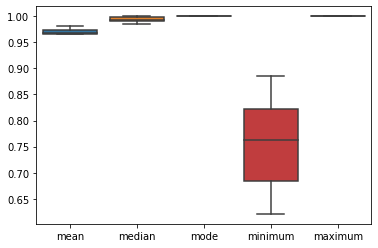

In [7]:
sns.boxplot(data=summary)

In [9]:
summary, cd = calc_coding_density(filestub='Bc01.fasta')

/home/edwa0468/.local/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 123 CDS and 19 tRNA
Skipped feature of type: source
Found 123 CDS and 20 tRNA
Skipped feature of type: source
Found 119 CDS and 22 tRNA
Skipped feature of type: source
Found 112 CDS and 20 tRNA
Skipped feature of type: source
Found 100 CDS and 13 tRNA
Skipped feature of type: source
Found 118 CDS and 22 tRNA
Skipped feature of type: source
Found 96 CDS and 9 tRNA


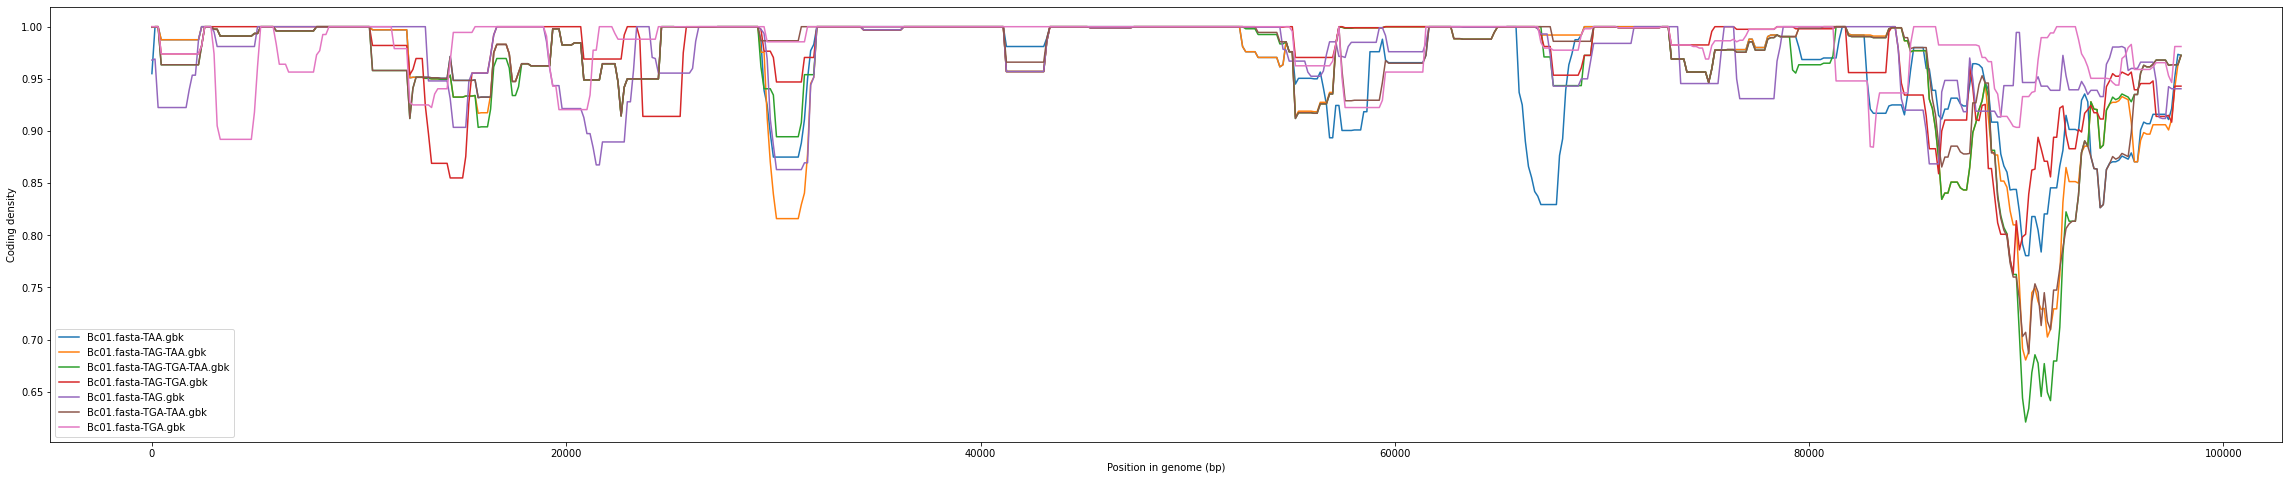

In [10]:
g = cd.plot(x='x', figsize=(40, 8))
t = g.set_xlabel('Position in genome (bp)')
t = g.set_ylabel('Coding density')
plt.savefig('coding_density.png')

/home/edwa0468/.local/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
Skipped feature of type: source
Found 143 CDS and 0 tRNA
Skipped feature of type: source
Found 287 CDS and 0 tRNA
Skipped feature of type: source
Found 278 CDS and 0 tRNA
Skipped feature of type: source
Found 288 CDS and 0 tRNA
Skipped feature of type: source
Found 212 CDS and 0 tRNA
Skipped feature of type: source
Found 138 CDS and 0 tRNA
Skipped feature of type: source
Found 101 CDS and 0 tRNA
Skipped feature of type: source
Found 141 CDS and 5 tRNA
Skipped feature of type: source
Found 284 CDS and 4 tRNA
Skipped feature of type: source
Found 277 CDS and 4 tRNA
Skipped feature of type: source
Found 289 CDS and 3 tRNA
Skipped feature of type: source
Found 212 CDS and 1 tRNA
Skipped feature of type: source
Found 137 CDS and 5 tRNA
Skipped feature of type: sour

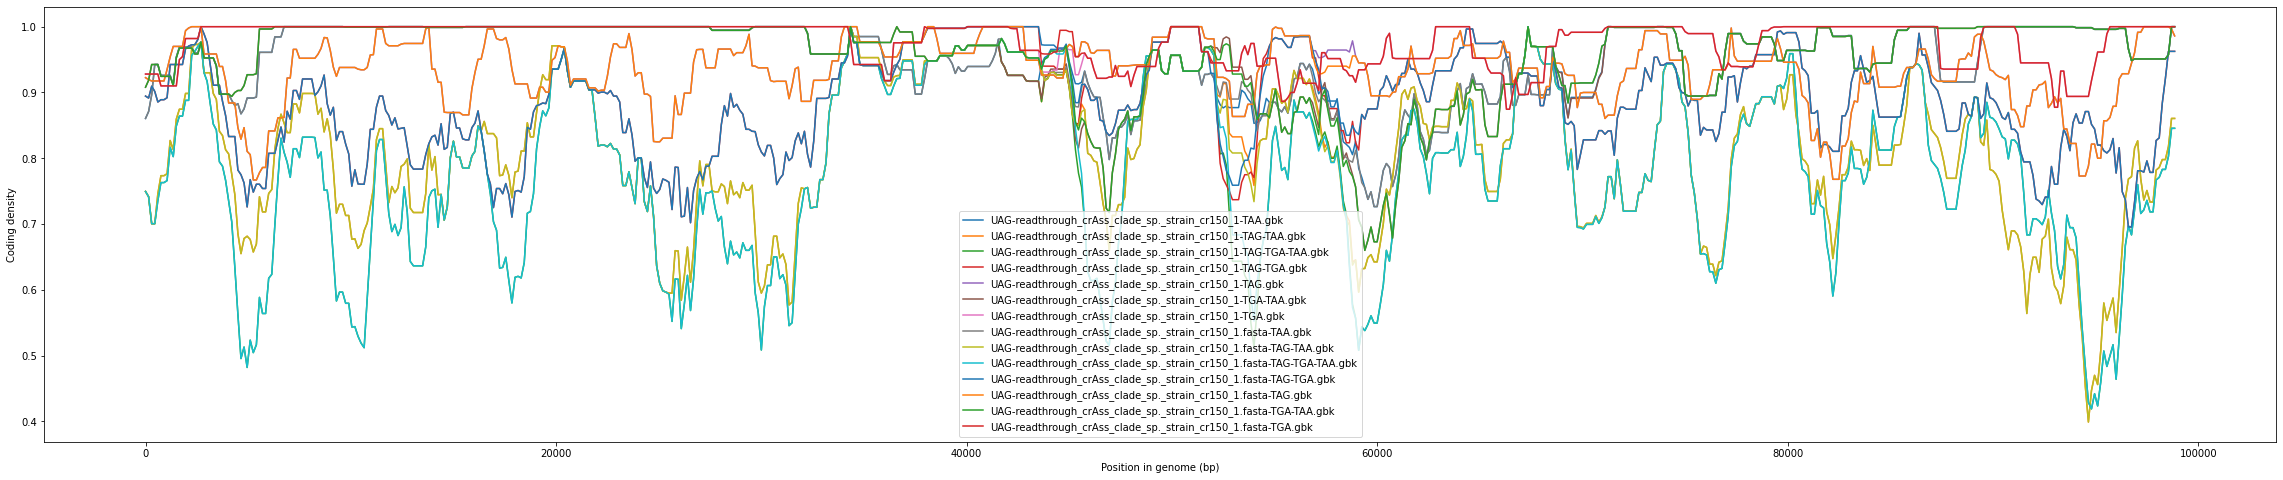

In [11]:
summary, cd = calc_coding_density(filestub='UAG-readthrough_crAss_clade')
g = cd.plot(x='x', figsize=(40, 8))
t = g.set_xlabel('Position in genome (bp)')
t = g.set_ylabel('Coding density')
plt.savefig('coding_density.png')